# Binospec Pointing Run  2020/07/08

On the night of July 8, 2020, a pointing run was carried out using Binospec's Single-Object Guider. This is the most convenient way to acquire pointing data with the f/5 configuration. It places an imaging camera at the center-of-rotation of the f/5 field-of-view with no extra re-imaging optics or mechanical stages. The pointing data was acquired while keeping the hexapod platform coordinates fixed. Pointing corrections due to tube flexure are performed using the hexapod to help maintain alignment between the optical axes of M1 and M2. The goal here was to measure the flexure using the mount and then use that to update the pointing models for both the mount and hexapod. 

Pointing data acquired with the mount is analyzed using [`tpoint`](http://www.tpointsw.uk/tpoint.htm) and `tpoint` models are implemented directly in the mount software. The MMTO's licensed copy of `tpoint` has been packaged into a Docker container so that it can be run on any platform Docker supports with no other dependencies. Information on how this container is built and run can be found at [https://github.com/MMTObservatory/tpoint_docker](https://github.com/MMTObservatory/tpoint_docker).

The MMTO's mount software implements the standard `tpoint` terms for alt-azimuth telescopes plus two tube flexure terms. The implemented terms are as follows:

| Term    |                 Description                |             Formulae                 |
|:--      |:-------------------------------------------|------------------------------------:|
|  `IA`   | Zero-point offset in azimuth               | $\Delta A = -\mathtt{IA}$           |
|  `IE`   | Zero-point offset in elevation             | $\Delta E = +\mathtt{IE}$           |
| `NPAE`  | Az/El non-perpindicularity                 | $\Delta A \simeq -\mathtt{NPAE} \tan(E)$ |
|  `CA`   | Non-perpindicularity between pointing direction and elevation axis | $\Delta A \simeq -\mathtt{CA} \sec(E)$ |
|  `AN`   | North-south misalignment of azimuth axis   | $\Delta A \simeq -\mathtt{AN} \sin(A) \tan(E)$; $\Delta E \simeq -\mathtt{AN} \cos(A)$ |
|  `AW`   | East-west misalignment of azimuth axis     | $\Delta A \simeq -\mathtt{AW} \cos(A) \tan(E)$; $\Delta E \simeq +\mathtt{AW} \sin(A)$ |
|  `TF`   | Classical tube flexure proportional to $\cos(E)$ | $\Delta E \simeq -\mathtt{TF} \cos(E)$ |
|  `TX`   | Empirical tube flexure proportional to $\frac{1}{\tan(E)}$ | $\Delta E \simeq \frac{-\mathtt{TX}}{\tan(E)}$ |


The current pointing model in the mount is based on pointing data taken with f/9 on 5/21/2007:
```
      1     IA         -0.026  +1191.16    1.289
      2     IE         -0.385     -1.81    0.304
      3     NPAE       -0.060     -4.23    1.533
      4     CA         +0.049    +16.71    1.878
      5     AN         +0.019     -1.32    0.103
      6     AW         +0.002    -13.25    0.103
      7     TF         +3.111     +7.65    0.889
      8     TX         -0.829     -2.80    0.291
            Sky RMS =   1.15
            Popn SD =   1.18
```
The `TF` term is actually set to 0 within the mount software since it was expected to be handled by the secondary mirror's hexapod and calibrated with different data, so-called "elcoll" runs. However, the `TX` term is *not* set to 0 within the mount and it should be. This is the first thing we should fix, though fortunately the effect isn't too large at the elevations we observe at.

A total of 73 pointing measurements were collected on 2020-07-08. Fitting the 8-term model to whole data set yields:
```
       coeff       change     value    sigma

  1     IA      +1206.365  +1206.37    6.235
  2     IE        -52.138    -52.14    1.503
  3     NPAE       -1.433     -1.43    6.370
  4     CA         +4.220     +4.22    8.486
  5     AN         +2.093     +2.09    0.373
  6     AW        -12.632    -12.63    0.365
  7     TF        -46.121    -46.12    3.566
  8     TX         -2.970     -2.97    0.950

Sky RMS =   2.71
Popn SD =   2.87
```

However, a significant part of the sky RMS comes from 3 outlier points with residuals of >6". Masking those data points out and re-doing the fit yields:
```
       coeff       change     value    sigma

  1     IA         -0.363  +1206.00    3.302
  2     IE         +0.420    -51.72    0.790
  3     NPAE       -0.728     -2.16    3.366
  4     CA         +0.589     +4.81    4.485
  5     AN         +0.284     +2.38    0.196
  6     AW         +0.271    -12.36    0.193
  7     TF         +6.064    -40.06    1.889
  8     TX         -1.580     -4.55    0.502

Sky RMS =   1.41
Popn SD =   1.50
```

The residuals to this fit show some small cyclical behavior as a function of azimuth. Taking the fit further by adding a harmonic term proportional to $\sin(A)$, `HESA`, and then masking the two points with residuals >2" yields:
```
       coeff       change     value    sigma

  1     IA         -0.692  +1205.27    1.799
  2     IE         +0.899    -50.82    0.433
  3     NPAE       -0.614     -2.80    1.826
  4     CA         +0.842     +5.71    2.436
  5     AN         +0.178     +2.55    0.107
  6     AW         -0.053    -12.58    0.181
  7     TF         +2.719    -37.32    1.044
  8     TX         -0.600     -5.16    0.275
  9     HESA       +0.408     +0.66    0.224

Sky RMS =   0.76
Popn SD =   0.82
```

A sky RMS of 0.76" over 68 stars is really very good! The harmonic component ends up being less than 1" in amplitude so we can lose it and re-do the 8-term fit over the 68 stars to get:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1205.44    1.908
  2     IE         -0.000    -50.85    0.459
  3     NPAE       -0.000     -2.69    1.938
  4     CA         +0.000     +5.49    2.585
  5     AN         -0.000     +2.55    0.114
  6     AW         -0.000    -12.15    0.113
  7     TF         -0.000    -37.46    1.107
  8     TX         +0.000     -5.11    0.291

Sky RMS =   0.81
Popn SD =   0.86
```

Sub-arcsecond sky RMS for the standard 8-term model is as good as we've ever done at the MMTO. This shows that the mount is very capable of sub-arcsecond open-loop pointing accuracy. The remaining challenge is in getting the pointing models for the M2 hexapods to be similarly deterministic.

In [1]:
import matplotlib
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
el = np.linspace(15, 90, 100) * u.deg

In [13]:
zc_trans = 9.453
zc_sky = 0.3
tf = -37.46
tx = -5.11

In [14]:
tiltx_cos_coeff = -1*tf / zc_sky
tiltx_tan_coeff = -1*tx / zc_sky
y_cos_coeff = zc_trans * tiltx_cos_coeff
y_tan_coeff = zc_trans * tiltx_tan_coeff
tiltx_cos_coeff, y_cos_coeff

(133.46666666666667, 1261.6604)

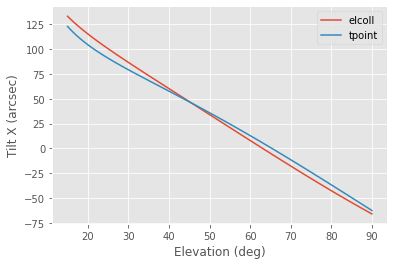

In [15]:
current_model = 119.6*np.cos(el) - 66.1*np.sin(el) + (2.8/zc_sky) * np.cos(el)/np.sin(el)
tpoint_model = tiltx_cos_coeff*np.cos(el) + tiltx_tan_coeff * np.cos(el)/np.sin(el)
mean_diff = np.mean(tpoint_model - current_model)
tpoint_model -= mean_diff
plt.plot(el, current_model, label="elcoll")
plt.plot(el, tpoint_model, label="tpoint")
plt.ylabel("Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()

In [9]:
print(mean_diff)

59.60707374568764
